# Exploración Inicial de los Datos (imágenes 3D)

## Contexto del Dataset

Este análisis se basa en el dataset **MAMA-MIA**, un benchmark público de resonancias magnéticas dinámicas (DCE-MRI) de mama para investigación en inteligencia artificial. El dataset incluye 1506 casos provenientes de 4 estudios clínicos multicéntricos (ISPY1, ISPY2, DUKE, NACT).

- Cada caso incluye múltiples fases de imagen (pre- y post-contraste).
- Las segmentaciones tumorales fueron inicialmente generadas por un modelo `nnU-Net`, y luego **corregidas por 16 expertos en mama**.
- Se utiliza la imagen `*_0000.nii.gz` como referencia principal para este análisis, ya que:
  - Es la fase pre-contraste.
  - Está alineada con las segmentaciones proporcionadas.
  - Es la fase más uniforme y menos sensible a variaciones en contraste o movimiento.

> Este enfoque está alineado con la metodología descrita en el paper original de referencia:  
> [A large-scale multicenter breast cancer DCE-MRI benchmark dataset with expert segmentations](https://doi.org/10.1038/s41597-025-04707-4)


Se encontraron 7926 imágenes
Archivo: duke_001_0000.nii.gz
Forma: (448, 448, 160)
Tipo de dato: float64
Rango de intensidades: 0.0 a 361.0


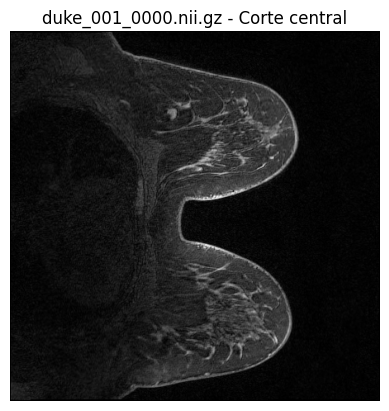

In [8]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Ruta donde tienes las imágenes
carpeta_imagenes = 'datos/images'

# Filtrar solo archivos .nii.gz
archivos = [f for f in os.listdir(carpeta_imagenes) if f.endswith('.nii.gz')]

print(f"Se encontraron {len(archivos)} imágenes")

# Procesar la primera imagen como ejemplo
primer_archivo = archivos[0]
ruta = os.path.join(carpeta_imagenes, primer_archivo)

# Cargar la imagen
img = nib.load(ruta)
data = img.get_fdata()

# Mostrar información
print(f"Archivo: {primer_archivo}")
print(f"Forma: {data.shape}")
print(f"Tipo de dato: {data.dtype}")
print(f"Rango de intensidades: {np.min(data)} a {np.max(data)}")

# Visualizar el corte central
slice_central = data.shape[2] // 2
plt.imshow(data[:, :, slice_central], cmap='gray')
plt.title(f"{primer_archivo} - Corte central")
plt.axis('off')
plt.show()



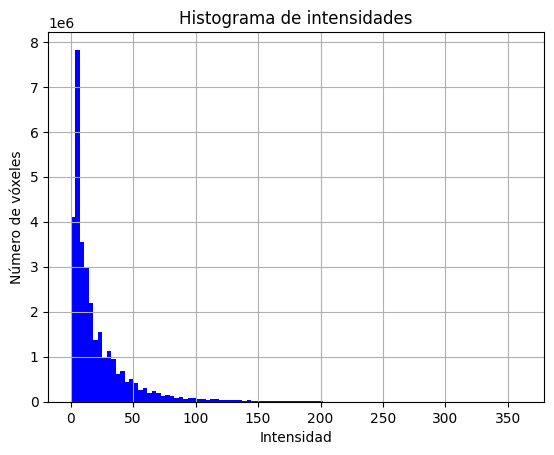

In [9]:
# Asegúrate de tener cargado 'data' como antes (la imagen)
import matplotlib.pyplot as plt

plt.hist(data.flatten(), bins=100, color='blue')
plt.title("Histograma de intensidades")
plt.xlabel("Intensidad")
plt.ylabel("Número de vóxeles")
plt.grid(True)
plt.show()


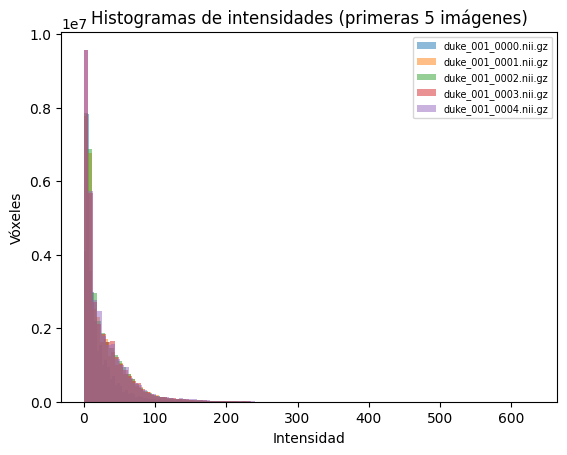

In [10]:
for i, archivo in enumerate(archivos[:5]):
    ruta = os.path.join(carpeta_imagenes, archivo)
    data = nib.load(ruta).get_fdata()
    plt.hist(data.flatten(), bins=100, alpha=0.5, label=archivo)

plt.title("Histogramas de intensidades (primeras 5 imágenes)")
plt.xlabel("Intensidad")
plt.ylabel("Vóxeles")
plt.legend(loc='upper right', fontsize='x-small')
plt.show()


# Segmentación

In [12]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Ruta a la imagen original y a su segmentación experta
imagen_path = 'datos/images/duke_001_0000.nii.gz'
mascara_path = 'datos/segmentations/expert/duke_001.nii.gz'

# Cargar imagen y máscara
img = nib.load(imagen_path).get_fdata()
mask = nib.load(mascara_path).get_fdata()

# Mostrar forma y valores únicos en la máscara
print(f"Shape de la máscara: {mask.shape}")
print("Valores únicos (etiquetas):", np.unique(mask))


Shape de la máscara: (448, 448, 160)
Valores únicos (etiquetas): [0. 1.]


In [13]:
from scipy.ndimage import label

labeled, num_tumores = label(mask)
print(f"Tumores encontrados (regiones conectadas): {num_tumores}")


Tumores encontrados (regiones conectadas): 3


In [14]:
porcentaje = 100 * np.sum(mask > 0) / np.prod(mask.shape)
print(f"Porcentaje del volumen que es tumor: {porcentaje:.4f}%")


Porcentaje del volumen que es tumor: 0.0233%


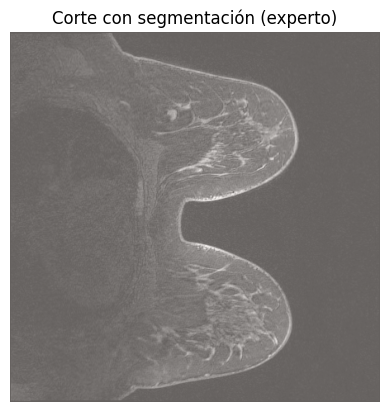

In [15]:
slice_central = img.shape[2] // 2

plt.imshow(img[:, :, slice_central], cmap='gray')
plt.imshow(mask[:, :, slice_central], cmap='Reds', alpha=0.4)
plt.title('Corte con segmentación (experto)')
plt.axis('off')
plt.show()


In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.ndimage import label

# Carpetas
carpeta_segmentaciones = 'datos/segmentations/expert'
carpeta_imagenes = 'datos/images'

# Archivos de segmentación
segmentaciones = [f for f in os.listdir(carpeta_segmentaciones) if f.endswith('.nii.gz')]

# Lista para resultados
resultados = []

for seg_file in segmentaciones:
    try:
        # Ruta a segmentación y a la imagen asociada (usamos la parte común del nombre)
        seg_path = os.path.join(carpeta_segmentaciones, seg_file)
        base_name = seg_file.split('.')[0]
        imagen_file = base_name + '_0000.nii.gz'
        img_path = os.path.join(carpeta_imagenes, imagen_file)

        # Cargar imagen y máscara
        img = nib.load(img_path).get_fdata()
        mask = nib.load(seg_path).get_fdata()

        # Estadísticas
        labeled, num_tumores = label(mask)
        porcentaje = 100 * np.sum(mask > 0) / np.prod(mask.shape)

        resultados.append({
            'paciente': base_name,
            'num_tumores': num_tumores,
            'porcentaje_tumor': porcentaje
        })

    except Exception as e:
        print(f"Error en {seg_file}: {e}")

# Guardar en DataFrame
df = pd.DataFrame(resultados)
print(df.head())


   paciente  num_tumores  porcentaje_tumor
0  duke_001            3          0.023284
1  duke_002            3          0.004599
2  duke_005           47          0.061568
3  duke_009           13          0.026099
4  duke_010           21          0.091636


In [18]:
df.to_csv('analisis_segmentaciones_expert.csv', index=False)


### EDA

Este análisis se centra en el estudio preliminar de las segmentaciones tumorales disponibles en el dataset MAMA-MIA. Para ello, se han considerado las segmentaciones proporcionadas por expertos (`segmentations/expert`) y se han cruzado con las imágenes base correspondientes (`*_0000.nii.gz`).

#### ¿Por qué se utiliza la imagen `*_0000.nii.gz`?

El dataset de imágenes 3D incluye múltiples fases por paciente (`*_0000.nii.gz`, `*_0001.nii.gz`, etc.), que representan distintos momentos de la adquisición (por ejemplo, antes y después del contraste).

La imagen `*_0000.nii.gz` ha sido seleccionada para este análisis porque:

- Es la imagen que **corresponde directamente con la segmentación experto/automática** (es la base sobre la que se realizaron).
- Representa la fase pre-contraste, que se usa como base anatómica.
- Permite un análisis consistente y comparable entre pacientes, ya que tiene menos artefactos, está disponible en todos los casos y no depende de la dinámica del contraste.

#### Métricas extraídas

Para cada máscara de segmentación se han calculado las siguientes métricas:

- `num_tumores`: número de componentes conectadas dentro de la máscara (posibles focos tumorales).
- `volumen_tumoral_%`: proporción del volumen ocupado por el tumor respecto al total de la imagen (expresado en porcentaje).

##### ¿Cómo se define un "tumor"?

Utilizamos la función `scipy.ndimage.label()` para detectar **componentes conectadas** en la segmentación binaria. Cada componente representa un grupo de vóxeles conectados espacialmente que pueden interpretarse como lesiones individuales. No se hace distinción en esta fase entre tumores grandes o pequeños.

> 🔧 *En futuras versiones se añadirá un umbral mínimo de tamaño para descartar falsos positivos de pequeño volumen.*

#### Datos guardados

Los resultados se almacenan en un archivo `.csv` para su análisis posterior:

- `paciente`: identificador del caso.
- `num_tumores`: cantidad de regiones conectadas detectadas.
- `volumen_tumoral_%`: porcentaje del volumen total ocupado por la segmentación.

Archivo generado: `analisis_segmentaciones_expert.csv`

---


In [19]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.ndimage import label

ruta_auto = 'datos/segmentations/automatic'
ruta_imgs = 'datos/images'

resultados_auto = []

for nombre_archivo in os.listdir(ruta_auto):
    if not nombre_archivo.endswith('.nii.gz'):
        continue

    try:
        # Ruta de la segmentación automática
        seg_path = os.path.join(ruta_auto, nombre_archivo)
        seg_data = nib.load(seg_path).get_fdata()

        # Ruta de la imagen asociada (0000)
        base_name = nombre_archivo.replace('.nii.gz', '_0000.nii.gz')
        img_path = os.path.join(ruta_imgs, base_name)
        img_data = nib.load(img_path).get_fdata()

        # Calcular número de tumores (componentes conectadas)
        labeled, num_tumores = label(seg_data)
        porcentaje = 100 * np.sum(seg_data > 0) / np.prod(seg_data.shape)

        resultados_auto.append({
            'paciente': nombre_archivo.replace('.nii.gz', ''),
            'num_tumores': num_tumores,
            'volumen_tumoral_%': porcentaje
        })

    except Exception as e:
        print(f"Error con {nombre_archivo}: {e}")

# Crear DataFrame
df_auto = pd.DataFrame(resultados_auto)

# Guardar como CSV
df_auto.to_csv('analisis_segmentaciones_automatic.csv', index=False)

# Mostrar algunas filas
print(df_auto.head())


   paciente  num_tumores  volumen_tumoral_%
0  duke_001            3           0.025193
1  duke_002            1           0.005384
2  duke_005           12           0.059930
3  duke_009           23           0.027013
4  duke_010            9           0.086703


## Juntamos ambos csv para comparar

In [21]:
import pandas as pd

# Cargar los análisis
df_expert = pd.read_csv('analisis_segmentaciones_expert.csv')
df_auto = pd.read_csv('analisis_segmentaciones_automatic.csv')

In [25]:
# Renombrar columnas para diferenciarlas
df_expert = df_expert.rename(columns={
    'num_tumores': 'tumores_expert',
    'porcentaje_tumor': 'volumen_expert'
})
df_auto = df_auto.rename(columns={
    'num_tumores': 'tumores_auto',
    'volumen_tumoral_%': 'volumen_auto'
})

# Unir por paciente
df_comparado = pd.merge(df_expert, df_auto, on='paciente', how='inner')

In [26]:
print("Columnas en df_expert:", df_expert.columns.tolist())
print("Columnas en df_auto:", df_auto.columns.tolist())


Columnas en df_expert: ['paciente', 'tumores_expert', 'volumen_expert']
Columnas en df_auto: ['paciente', 'tumores_auto', 'volumen_auto']


In [30]:


# Calcular diferencias
df_comparado['dif_tumores'] = df_comparado['tumores_auto'] - df_comparado['tumores_expert']
df_comparado['dif_volumen'] = df_comparado['volumen_auto'] - df_comparado['volumen_expert']

# Mostrar algunos resultados
print(df_comparado.head())
df_comparado.to_csv('comparacion_expert_auto.csv', index=False)


   paciente  tumores_expert  volumen_expert  tumores_auto  volumen_auto  \
0  duke_001               3        0.023284             3      0.025193   
1  duke_002               3        0.004599             1      0.005384   
2  duke_005              47        0.061568            12      0.059930   
3  duke_009              13        0.026099            23      0.027013   
4  duke_010              21        0.091636             9      0.086703   

   dif_tumores  dif_volumen  
0            0     0.001909  
1           -2     0.000784  
2          -35    -0.001638  
3           10     0.000915  
4          -12    -0.004933  


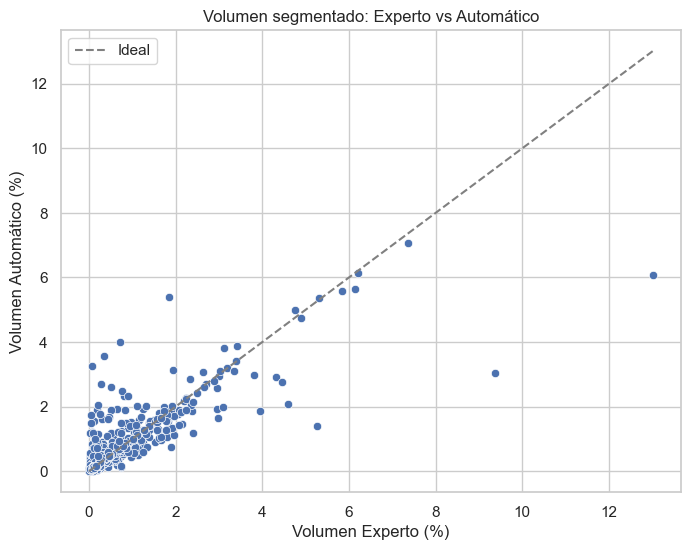

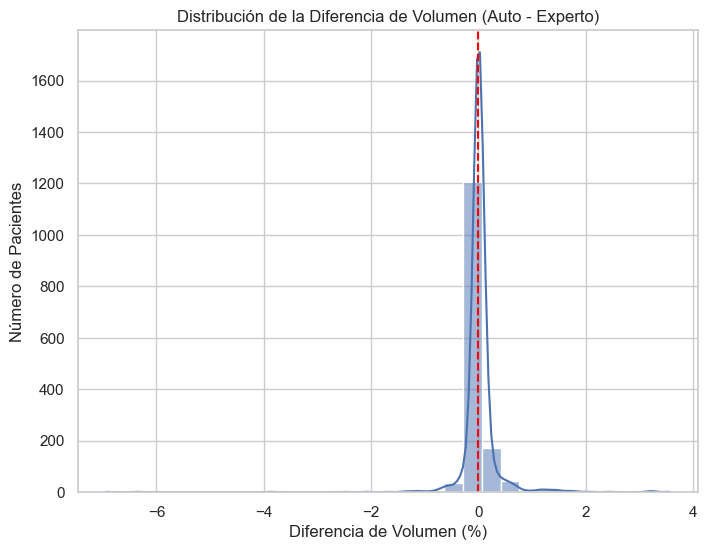

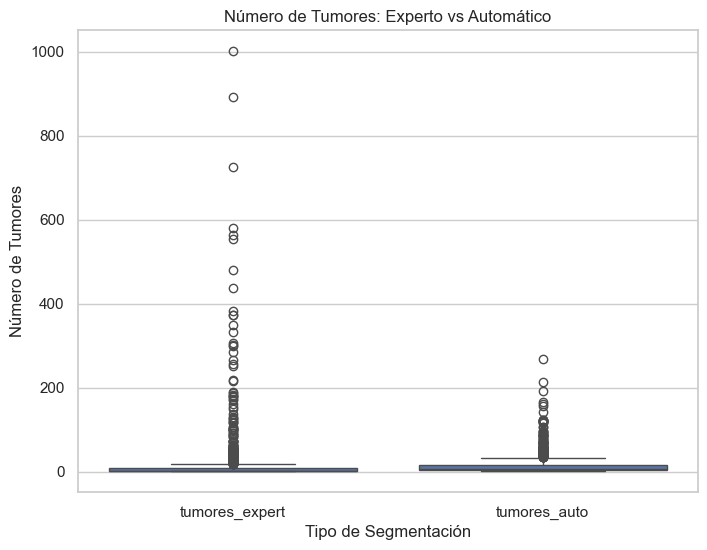

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar CSV con los datos comparados
df_comparado = pd.read_csv('comparacion_expert_auto.csv')

# Estilo de visualización
sns.set(style="whitegrid")

# 1. SCATTER: Volumen experto vs automático
plt.figure(figsize=(8,6))
sns.scatterplot(x='volumen_expert', y='volumen_auto', data=df_comparado)
plt.plot([0, max(df_comparado['volumen_expert'].max(), df_comparado['volumen_auto'].max())],
         [0, max(df_comparado['volumen_expert'].max(), df_comparado['volumen_auto'].max())],
         linestyle='--', color='gray', label='Ideal')
plt.title('Volumen segmentado: Experto vs Automático')
plt.xlabel('Volumen Experto (%)')
plt.ylabel('Volumen Automático (%)')
plt.legend()
plt.show()

# 2. HISTOGRAMA: Diferencia de volumen
plt.figure(figsize=(8,6))
sns.histplot(df_comparado['dif_volumen'], bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución de la Diferencia de Volumen (Auto - Experto)')
plt.xlabel('Diferencia de Volumen (%)')
plt.ylabel('Número de Pacientes')
plt.show()

# 3. BOXPLOT: Número de tumores
plt.figure(figsize=(8,6))
df_melt = df_comparado.melt(id_vars='paciente', value_vars=['tumores_expert', 'tumores_auto'],
                            var_name='tipo_segmentacion', value_name='num_tumores')
sns.boxplot(x='tipo_segmentacion', y='num_tumores', data=df_melt)
plt.title('Número de Tumores: Experto vs Automático')
plt.xlabel('Tipo de Segmentación')
plt.ylabel('Número de Tumores')
plt.show()


In [38]:
import pandas as pd

# Cargar el CSV con los datos comparados
df = pd.read_csv('comparacion_expert_auto.csv')

# Función para clasificar visibilidad
def clasificar_visibilidad(n_tumores, volumen):
    if volumen > 0.05 and n_tumores == 1:
        return 'Alta'
    elif volumen < 0.01 or n_tumores > 3:
        return 'Baja'
    else:
        return 'Media'

# Aplicar clasificación a ambas segmentaciones
df['visibilidad_expert'] = df.apply(lambda row: clasificar_visibilidad(row['tumores_expert'], row['volumen_expert']), axis=1)
df['visibilidad_auto'] = df.apply(lambda row: clasificar_visibilidad(row['tumores_auto'], row['volumen_auto']), axis=1)

# Guardar nuevo CSV con visibilidad añadida
output_path = 'comparacion_expert_auto_visibilidad.csv'
df.to_csv(output_path, index=False)
print(df.head())




   paciente  tumores_expert  volumen_expert  tumores_auto  volumen_auto  \
0  duke_001               3        0.023284             3      0.025193   
1  duke_002               3        0.004599             1      0.005384   
2  duke_005              47        0.061568            12      0.059930   
3  duke_009              13        0.026099            23      0.027013   
4  duke_010              21        0.091636             9      0.086703   

   dif_tumores  dif_volumen visibilidad_expert visibilidad_auto  
0            0     0.001909              Media            Media  
1           -2     0.000784               Baja             Baja  
2          -35    -0.001638               Baja             Baja  
3           10     0.000915               Baja             Baja  
4          -12    -0.004933               Baja             Baja  


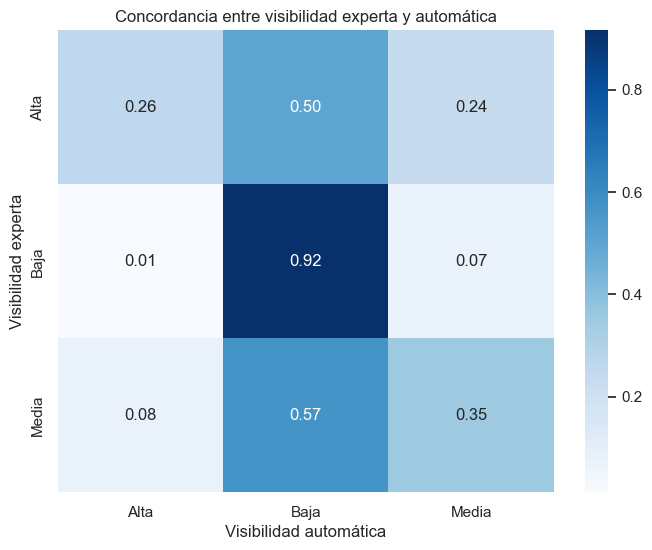

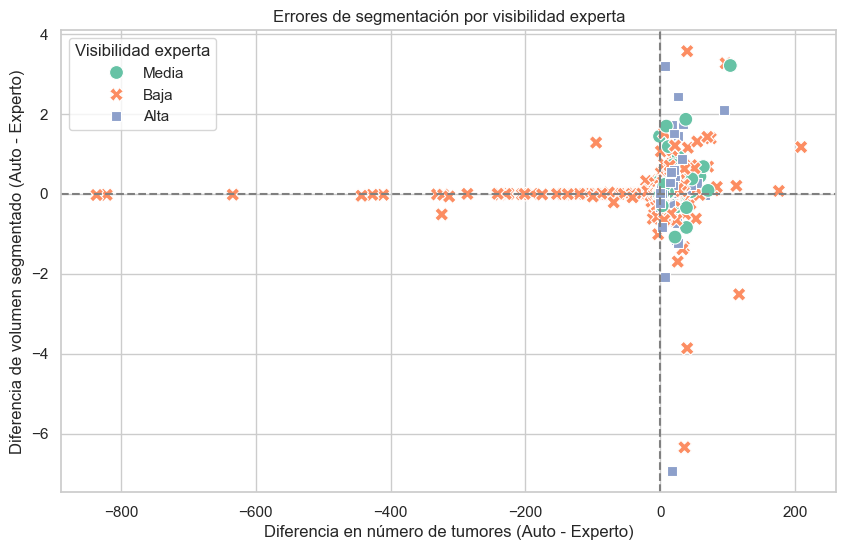

  visibilidad_expert  dif_tumores  dif_volumen
0               Alta       5.3974       0.0287
1               Baja     -13.5386       0.0093
2              Media       5.8685       0.0438


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Configurar estilo visual
sns.set(style="whitegrid")

# 1. Heatmap de concordancia entre visibilidad experta y automática
conf_matrix = pd.crosstab(df['visibilidad_expert'], df['visibilidad_auto'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Concordancia entre visibilidad experta y automática')
plt.xlabel('Visibilidad automática')
plt.ylabel('Visibilidad experta')
plt.show()

# 2. Scatter plot: diferencia de volumen vs diferencia de tumores, coloreado por visibilidad experta
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='dif_tumores', y='dif_volumen', hue='visibilidad_expert', style='visibilidad_expert', palette='Set2', s=100)
plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')
plt.title('Errores de segmentación por visibilidad experta')
plt.xlabel('Diferencia en número de tumores (Auto - Experto)')
plt.ylabel('Diferencia de volumen segmentado (Auto - Experto)')
plt.legend(title='Visibilidad experta')
plt.grid(True)
plt.show()

# 3. Tabla resumen con medias por visibilidad experta
resumen = df.groupby('visibilidad_expert')[['dif_tumores', 'dif_volumen']].mean().round(4)
resumen.reset_index(inplace=True)
print(resumen)


## 📊 Análisis de Segmentaciones según Visibilidad Tumoral

En este análisis se estudia **cómo varían los errores de la segmentación automática frente a la experta**, dependiendo del nivel de **visibilidad del tumor**.

La **visibilidad** se ha calculado tanto para la segmentación experta como para la automática, basándose en:
- El **volumen tumoral segmentado** (en porcentaje del volumen total).
- El **número de componentes conectadas** (tumores separados).

Se han definido tres niveles de visibilidad:
- **Alta**: Tumor único y de gran tamaño.
- **Media**: Intermedia en número de tumores y volumen.
- **Baja**: Múltiples tumores o volumen muy pequeño.

> En este análisis, tomamos la **visibilidad experta** como referencia para evaluar la calidad de las segmentaciones automáticas. Además, comparamos la clasificación de visibilidad entre ambos métodos para estudiar la concordancia.

---

###  1. Concordancia entre visibilidad experta y automática

- La matriz de confusión muestra cómo se alinean las clasificaciones de visibilidad de ambos métodos.
- La **concordancia es mayor en los casos de baja visibilidad** (92%), lo cual sugiere que el modelo identifica bien estos casos.
- En cambio, para los **tumores de alta visibilidad**, el modelo automático tiende a clasificarlos erróneamente como "media" o incluso "baja", lo cual indica un **sesgo hacia la simplificación**.

---

### 2. Errores de segmentación según visibilidad experta

- Cada punto representa un paciente, mostrando la diferencia entre modelo automático y experto en:
  - Eje X: número de tumores.
  - Eje Y: volumen tumoral.
- Los errores se agrupan según la visibilidad experta:
  - **Baja visibilidad**: Mayor dispersión y errores más extremos.
  - **Media/Alta visibilidad**: Mejores resultados, errores más controlados.

---

### 3. Resumen de errores medios por visibilidad experta

| Visibilidad | ∆ Tumores (Auto - Expert) | ∆ Volumen (%) |
|-------------|----------------------------|----------------|
| Alta        | **+5.40** → sobresegmentación | **+0.0287** |
| Media       | **+5.87** → sobresegmentación | **+0.0438** |
| Baja        | **-13.54** → subsegmentación | **+0.0093** |

- El modelo **subsegmenta tumores** en casos de baja visibilidad (omite focos).
- En tumores de media y alta visibilidad, tiende a **sobresegmentar**, detectando más regiones o extendiendo el volumen.

---

### ✅ Conclusión

> El modelo automático muestra **diferencias claras en rendimiento según la visibilidad del tumor**. Los casos difíciles (baja visibilidad) siguen siendo un reto, lo cual sugiere la necesidad de:
>
> - Mejorar la sensibilidad del modelo.
> - Incluir mecanismos de control de calidad.
> - Aplicar estrategias específicas para tumores pequeños o multifocales.

